
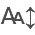

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

import matplotlib.patches as mpatches

import pandas as pd
import numpy as np

from scipy.stats import pearsonr 
from joblib import Parallel, delayed

# import urllib.request
import fastobo

import json

import goatools
from goatools.obo_parser import GODag

import itables.options as opt
from itables import init_notebook_mode, show
from itables.downsample import as_nbytes, nbytes
from itables.sample_dfs import get_indicators

init_notebook_mode(all_interactive=False)
opt.maxBytes = "128KB"

import seaborn as sns

sns.set()
plt.style.use('default')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, BoundaryNorm


In [2]:
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['axes.titlesize'] = 20

## Abro datos:

### **Datos de proteinas en Yeast**

Columns are:

1. **DB** - database contributing the file (always "SGD" for this file)

2. **DB_Object_ID** - SGDID
3. **DB_Object_Symbol** - When a Standard Gene Name (e.g. CDC28, COX2) has been conferred, it will be present in Column 3. When no Gene Name has been conferred, the Systematic Name (e.g. YAL001C, YGR116W, YAL034W-A) will be present in column 3.

4. **NOT** (optional) - 'NOT', 'contributes_to', or 'colocalizes_with' qualifier for a GO annotation, when needed
5. **GO ID** - unique numeric identifier for the GO term
6. **DB:Reference(|DB:Reference)** - the reference associated with the GO annotation
7. **Evidence** - the evidence code for the GO annotation
8. **With (or) From** (optional) - any With or From qualifier for the GO annotation
9. **Aspect** - which ontology the GO term belongs in
10. **DB_Object_Name(|Name)** (optional) - a name for the gene product in words, e.g. 'acid phosphatase'
11. **DB_Object_Synonym(|Synonym)** (optional) - The Systematic Name (e.g. YAL001C, YGR116W, YAL034W-A, Q0010) will be the first name present in Column 11. Any other names (except the Standard Name, which will be in Column 3 if	one exists), including Aliases used for the gene will also be present in this column.

12. **DB_Object_Type** - type of object annotated, e.g. gene, protein, etc.
13. **taxon(|taxon)** - taxonomic identifier of species encoding gene product
14. **Date** - date GO annotation was made
15. **Assigned_by** - source of the annotation (e.g. SGD, UniProtKB, YeastFunc, bioPIXIE_MEFIT)

In [200]:
gaf_df = pd.read_csv('../../Datos/gene_association.sgd.20241028.gaf', sep='\t', comment='!', header=None, low_memory=False)
short_headers = ["DB", "SGDID", "Symbol", "Qualifier", "GO_ID", "Reference", "Evidence", 
	"With_From", "Aspect", "Name", "Synonym", "Type", "Taxon", "Date", "Assigned_by1", "Assigned_by2", "Assigned_by3"]

gaf_df.columns = short_headers
gaf_df.head()

DB       SGDID Symbol                   Qualifier       GO_ID  \
0  SGD  S000003381   GPC1  acts_upstream_of_or_within  GO:0090640   
1  SGD  S000005701   ALE1  acts_upstream_of_or_within  GO:0090640   
2  SGD  S000003381   GPC1  acts_upstream_of_or_within  GO:0036151   
3  SGD  S000004492   RCF1  acts_upstream_of_or_within  GO:0033617   
4  SGD  S000004977  SIW14                     enables  GO:0052845   

       Reference Evidence       With_From Aspect  \
0  PMID:30514764      IGI  SGD:S000005701      P   
1  PMID:30514764      IGI  SGD:S000003381      P   
2  PMID:30514764      IMP             NaN      P   
3  PMID:29746825      IMP             NaN      P   
4  PMID:26828065      IDA             NaN      F   

                                                Name  \
0      Glycerophosphocholine acyltransferase (GPCAT)   
1  Broad-specificity lysophospholipid acyltransfe...   
2      Glycerophosphocholine acyltransferase (GPCAT)   
3                       Cytochrome c oxidase subunit   
4  Inositol phosphatase involved in inositol pyro...   

                                             Synonym     Type         Taxon  \
0      YGR149W|glycerophosphocholine acyltransferase  protein  taxon:559292   
1  YOR175C|SLC4|LPT1|LCA1|lysophospholipid acyltr...  protein  taxon:559292   
2      YGR149W|glycerophosphocholine acyltransferase  protein  taxon:559292   
3                                      YML030W|AIM31  protein  taxon:559292   
4  YNL032W|OCA3|putative tyrosine protein phospha...  protein  taxon:559292   

       Date Assigned_by1         Assigned_by2      Assigned_by3  
0  20181220          SGD                  NaN  UniProtKB:P48236  
1  20181220          SGD                  NaN  UniProtKB:Q08548  
2  20181220          SGD                  NaN  UniProtKB:P48236  
3  20181212          SGD                  NaN  UniProtKB:Q03713  
4  20190110          SGD  part_of(GO:0071543)  UniProtKB:P53965

In [201]:
# Tomo solo las columnas que me interesan:

df_proteinas = gaf_df[["SGDID", "Qualifier", "GO_ID", "With_From", "Synonym", "Type",  "Date"]].copy()
df_proteinas['Date'] = pd.to_datetime(df_proteinas['Date'], format='%Y%m%d')
df_proteinas.head()

SGDID                   Qualifier       GO_ID       With_From  \
0  S000003381  acts_upstream_of_or_within  GO:0090640  SGD:S000005701   
1  S000005701  acts_upstream_of_or_within  GO:0090640  SGD:S000003381   
2  S000003381  acts_upstream_of_or_within  GO:0036151             NaN   
3  S000004492  acts_upstream_of_or_within  GO:0033617             NaN   
4  S000004977                     enables  GO:0052845             NaN   

                                             Synonym     Type       Date  
0      YGR149W|glycerophosphocholine acyltransferase  protein 2018-12-20  
1  YOR175C|SLC4|LPT1|LCA1|lysophospholipid acyltr...  protein 2018-12-20  
2      YGR149W|glycerophosphocholine acyltransferase  protein 2018-12-20  
3                                      YML030W|AIM31  protein 2018-12-12  
4  YNL032W|OCA3|putative tyrosine protein phospha...  protein 2019-01-10

In [203]:
nombre_sistematico1 = df_proteinas['Synonym'].str.split('|').str[0]

# nombre_sistematico2 = df_proteinas['Synonym'].str.split('|').str[1]
df_proteinas['Nombre'] = nombre_sistematico1
# df_proteinas['Nombre2'] = nombre_sistematico2
df_proteinas['Index'] = df_proteinas.index

df_proteinas = df_proteinas[['Nombre', 'Date', 'SGDID', 'GO_ID', 'Qualifier', 'With_From', 'Synonym', 'Type' ]]
df_proteinas.head()

Nombre       Date       SGDID       GO_ID                   Qualifier  \
0  YGR149W 2018-12-20  S000003381  GO:0090640  acts_upstream_of_or_within   
1  YOR175C 2018-12-20  S000005701  GO:0090640  acts_upstream_of_or_within   
2  YGR149W 2018-12-20  S000003381  GO:0036151  acts_upstream_of_or_within   
3  YML030W 2018-12-12  S000004492  GO:0033617  acts_upstream_of_or_within   
4  YNL032W 2019-01-10  S000004977  GO:0052845                     enables   

        With_From                                            Synonym     Type  
0  SGD:S000005701      YGR149W|glycerophosphocholine acyltransferase  protein  
1  SGD:S000003381  YOR175C|SLC4|LPT1|LCA1|lysophospholipid acyltr...  protein  
2             NaN      YGR149W|glycerophosphocholine acyltransferase  protein  
3             NaN                                      YML030W|AIM31  protein  
4             NaN  YNL032W|OCA3|putative tyrosine protein phospha...  protein

## Arranco con los datos de transcriptomas

In [204]:
ruta_transc = '../../Datos/transcriptomas/breeden.tsv'
tran_df = pd.read_csv(ruta_transc, sep='\t')

tran_df['Proteina'] = tran_df.index
tran_df = tran_df.reset_index(drop=True)
tran_df = tran_df[['Proteina'] + [col for col in tran_df.columns if col != 'Proteina']]
tran_df.head()

Proteina  GSM112133  GSM112134  GSM112135  GSM112136  GSM112137  GSM112138  \
0  YAL001C  -0.172199  -0.176692  -0.128590  -0.220821  -0.051547  -0.121769   
1  YAL002W  -0.246357  -0.164149  -0.212927  -0.287199  -0.143381  -0.148758   
2  YAL003W   0.091947   0.081549   0.070837   0.063376   0.044508  -0.008903   
3  YAL004W   0.791379   0.213645   0.303273   0.128341   0.017595  -0.038509   
4  YAL005C  -0.002195   0.192435   0.138695   0.033640  -0.011954  -0.102369   

   GSM112139  GSM112140  GSM112141  ...  GSM112148  GSM112149  GSM112150  \
0  -0.134030  -0.005316  -0.042889  ...  -0.029420  -0.097445  -0.022485   
1  -0.234190  -0.105236  -0.094954  ...  -0.086529  -0.099139  -0.086668   
2  -0.010576  -0.020787  -0.037553  ...   0.026706   0.046424  -0.031852   
3  -0.070606  -0.063356  -0.064029  ...   0.061475   0.118078   0.077254   
4  -0.123758  -0.152752  -0.091007  ...   0.118397   0.125501   0.043705   

   GSM112151  GSM112152  GSM112153  GSM112154  GSM112155  GSM112156  GSM112157  
0  -0.036959  -0.043474  -0.088562   0.030042   0.052682   0.030987  -0.089989  
1  -0.040772  -0.035629  -0.094914   0.235969   0.044702   0.048027  -0.056970  
2  -0.003595   0.021282   0.003498   0.053277   0.017594  -0.006687  -0.019525  
3   0.079558  -0.008287   0.284459   0.684856   0.285945   0.436625   0.171254  
4   0.064237   0.038632  -0.011199   0.207420  -0.033099   0.023944   0.012735  

[5 rows x 26 columns]

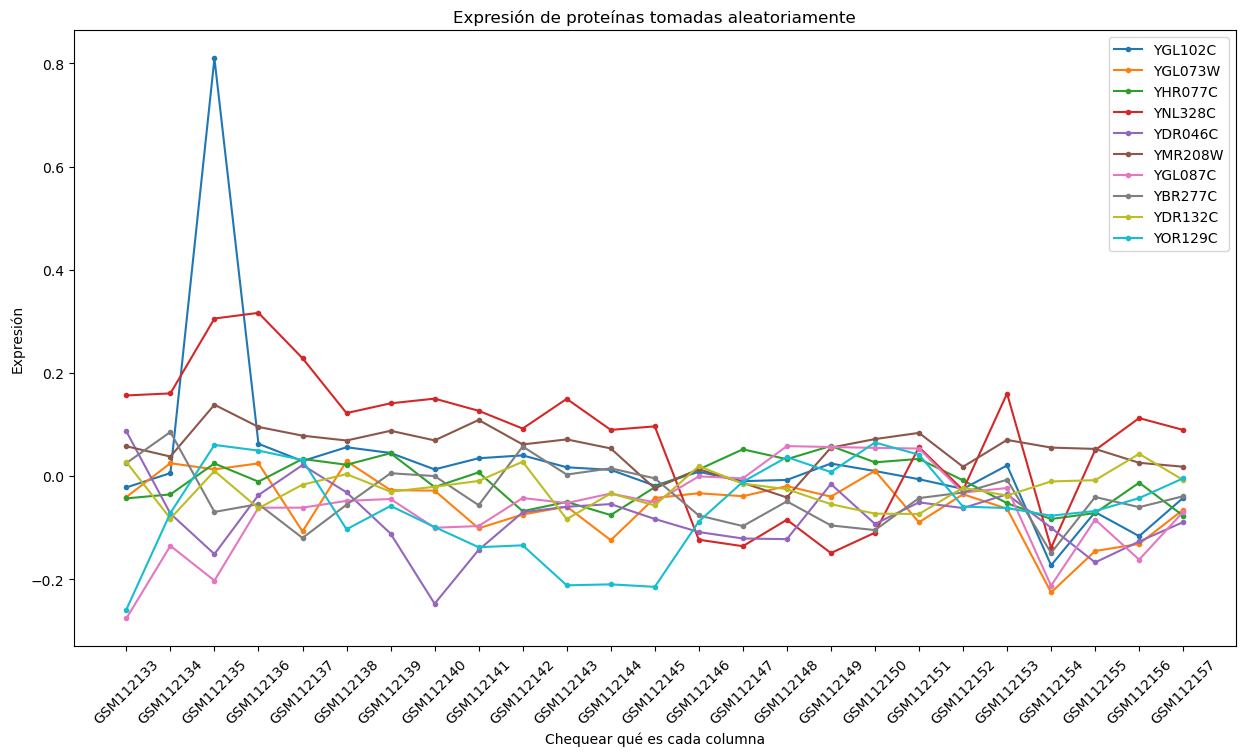

In [188]:
filas = np.random.randint(0, tran_df.shape[0], 10, dtype=int)

plt.figure(figsize = (15, 8))
for i in filas:
	
	plt.plot(tran_df.iloc[i][1:], '.-', label = tran_df.iloc[i]['Proteina'])
	plt.legend()
	plt.xticks(rotation=45, fontsize = 10)
	plt.ylabel('Expresión')
	plt.xlabel('Chequear qué es cada columna')
	plt.title('Expresión de proteínas tomadas aleatoriamente')

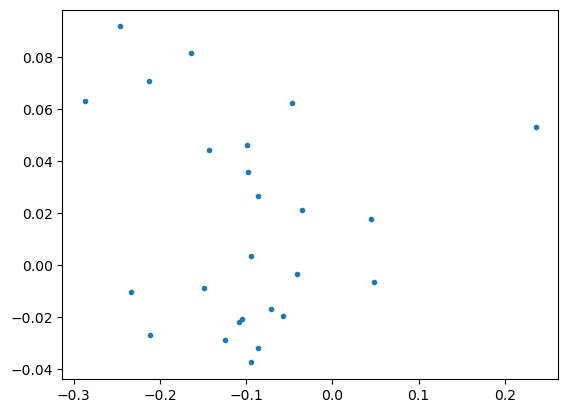

In [191]:
plt.plot(tran_df.iloc[1][1:], tran_df.iloc[2][1:], '.', label = tran_df.iloc[i]['Proteina'])

In [173]:
def calcular_pearson(df, i, j):
    x = df.iloc[i][1:]
    y = df.iloc[j][1:]

    has_nan_x = pd.isnull(x).any()
    has_nan_y = pd.isnull(y).any()

    if has_nan_x or has_nan_y:
        nan_indices = x[pd.isnull(x)].index.union(y[pd.isnull(y)].index)
        yy = y.drop(nan_indices)
        xx = x.drop(nan_indices)
        return pearsonr(xx, yy)[0]
    else:
        return pearsonr(x, y)[0]


In [177]:
def generar_matriz_pearson_paralelizada(df, n_jobs=-1):
    tamaño = df.shape[0]
    matriz_pearson = np.zeros((tamaño, tamaño))
    matriz_df = pd.DataFrame(matriz_pearson, columns=df['Proteina'], index=df['Proteina'])

    # Generar todas las combinaciones (i, j) para i <= j
    indices = [(i, j) for i in range(tamaño) for j in range(i, tamaño)]

    # Paralelizar el cálculo usando joblib
    resultados = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(calcular_pearson)(df, i, j) for i, j in indices
    )

    # Asignar los resultados a la matriz
    for (i, j), pearson in zip(indices, resultados):
        matriz_df.iloc[i, j] = pearson
        matriz_df.iloc[j, i] = pearson  # Llenar la matriz simétrica

    return matriz_df

In [183]:
tran_df.shape

(6217, 26)

In [ ]:
# n = 11
# tran_df_prueba = tran_df.iloc[n:n+50]

# matriz_df = generar_matriz_pearson(tran_df_prueba)
matriz_df = generar_matriz_pearson_paralelizada(tran_df,  n_jobs=4) # 2 horas con 4 nucleos
matriz_df

Proteina   YAL001C   YAL002W   YAL003W   YAL004W   YAL005C   YAL007C  \
Proteina                                                               
YAL001C   1.000000  0.784409 -0.255929 -0.000721  0.124635 -0.135642   
YAL002W   0.784409  1.000000 -0.123425  0.319548  0.328560 -0.291349   
YAL003W  -0.255929 -0.123425  1.000000  0.547065  0.622235  0.410656   
YAL004W  -0.000721  0.319548  0.547065  1.000000  0.421385  0.195020   
YAL005C   0.124635  0.328560  0.622235  0.421385  1.000000  0.490343   
...            ...       ...       ...       ...       ...       ...   
YPR199C  -0.057262 -0.187421 -0.266689 -0.556235 -0.192349 -0.175384   
YPR200C  -0.237002 -0.604758  0.030231 -0.384033 -0.362241  0.328341   
YPR201W   0.371669  0.149767 -0.170058  0.010244 -0.150002  0.061394   
YPR202W   0.053529  0.125068 -0.161563  0.374832 -0.149757  0.131102   
YPR203W   0.024929  0.234124 -0.110182  0.544893  0.049754  0.201957   

Proteina   YAL008W   YAL009W   YAL010C   YAL011W  ...   YPR194C   YPR195C  \
Proteina                                          ...                       
YAL001C   0.068274 -0.208016 -0.299033  0.302697  ...  0.110906  0.192338   
YAL002W  -0.001941 -0.428036 -0.446571  0.461013  ... -0.267790  0.156363   
YAL003W   0.247240 -0.175059 -0.003965  0.073686  ... -0.376035  0.005696   
YAL004W   0.078229 -0.540098 -0.166937  0.130986  ... -0.343021  0.282223   
YAL005C   0.529234 -0.297900 -0.515094  0.285265  ... -0.578441 -0.027009   
...            ...       ...       ...       ...  ...       ...       ...   
YPR199C  -0.003728  0.566340 -0.124162  0.201184  ...  0.336640 -0.143068   
YPR200C  -0.148681  0.230210  0.359281 -0.338900  ...  0.527433 -0.019971   
YPR201W  -0.230815 -0.116290  0.056176 -0.414752  ... -0.120009  0.221863   
YPR202W  -0.196000 -0.243350 -0.109921 -0.252049  ... -0.088322  0.392508   
YPR203W  -0.127782 -0.314147 -0.222125 -0.109903  ... -0.127888  0.344333   

Proteina   YPR196W   YPR197C   YPR198W   YPR199C   YPR200C   YPR201W  \
Proteina                                                               
YAL001C   0.053657 -0.280936  0.393633 -0.057262 -0.237002  0.371669   
YAL002W   0.049744 -0.305974  0.368092 -0.187421 -0.604758  0.149767   
YAL003W  -0.300600  0.077396 -0.619781 -0.266689  0.030231 -0.170058   
YAL004W  -0.040569  0.437393 -0.452444 -0.556235 -0.384033  0.010244   
YAL005C   0.012542 -0.418005 -0.374103 -0.192349 -0.362241 -0.150002   
...            ...       ...       ...       ...       ...       ...   
YPR199C  -0.121944 -0.361614  0.361338  1.000000  0.189258 -0.381692   
YPR200C   0.091711  0.187729 -0.198345  0.189258  1.000000  0.094894   
YPR201W   0.003551  0.115338 -0.179094 -0.381692  0.094894  1.000000   
YPR202W   0.298609  0.243676 -0.246702 -0.351813 -0.145606  0.452052   
YPR203W   0.362602  0.260880 -0.256586 -0.363288 -0.278559  0.217796   

Proteina   YPR202W   YPR203W  
Proteina                      
YAL001C   0.053529  0.024929  
YAL002W   0.125068  0.234124  
YAL003W  -0.161563 -0.110182  
YAL004W   0.374832  0.544893  
YAL005C  -0.149757  0.049754  
...            ...       ...  
YPR199C  -0.351813 -0.363288  
YPR200C  -0.145606 -0.278559  
YPR201W   0.452052  0.217796  
YPR202W   1.000000  0.900580  
YPR203W   0.900580  1.000000  

[6217 rows x 6217 columns]

In [202]:
matriz_df.to_csv('matriz_pearson_breeden.csv', header=True, index=True) #1 minuto en guardar la matriz simetrica

In [201]:
# Explorar despues esta idea

# import cupy as cp

# def generar_matriz_pearson_gpu(df):
#     # Convertir el DataFrame a una matriz CuPy
#     proteinas = df['Proteina']
#     data = cp.array(df.iloc[:, 1:].to_numpy(dtype=cp.float32)) 
#     tamaño = data.shape[0]

#     matriz_pearson = cp.zeros((tamaño, tamaño), dtype=cp.float32)

#     # Calcular la correlación de Pearson en GPU
#     for i in range(tamaño):
#         for j in range(i, tamaño):
#             x = data[i]
#             y = data[j]

#             mask = ~cp.isnan(x) & ~cp.isnan(y)
#             x_valid = x[mask]
#             y_valid = y[mask]

#             if len(x_valid) > 1 and len(y_valid) > 1:
#                 pearson = cp.corrcoef(x_valid, y_valid)[0, 1]
#             else:
#                 pearson = cp.nan

#             matriz_pearson[i, j] = pearson
#             matriz_pearson[j, i] = pearson  

#     matriz_pearson = cp.asnumpy(matriz_pearson) 
#     matriz_df = pd.DataFrame(
#         matriz_pearson, columns=proteinas, index=proteinas
#     )
#     return matriz_df


## Trabajo con la matriz de correlación 

In [192]:
def plot_heatmap(df, cantidad = -1, figsize = (12,12), **kwargs):

    imagen = df.copy().to_numpy()
    if cantidad == -1:
        imagen2 = imagen
    else:
	    imagen2 = imagen[:cantidad, :cantidad]

    fig, ax = plt.subplots(figsize=figsize)

    # Pasar kwargs correctamente a imshow
    im = ax.imshow(imagen2, **kwargs)

    # Configurar el colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1) 
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Coeficiente de correlación')

    plt.show()


In [193]:
matriz_pear = pd.read_csv('../../Datos/transcriptomas/Matrices_javi/matriz_pearson_breeden.csv')
matriz_pear = matriz_pear.set_index('Proteina')
matriz_pear.head()

YAL001C   YAL002W   YAL003W   YAL004W   YAL005C   YAL007C  \
Proteina                                                               
YAL001C   1.000000  0.784409 -0.255929 -0.000721  0.124635 -0.135642   
YAL002W   0.784409  1.000000 -0.123425  0.319548  0.328560 -0.291349   
YAL003W  -0.255929 -0.123425  1.000000  0.547065  0.622235  0.410656   
YAL004W  -0.000721  0.319548  0.547065  1.000000  0.421385  0.195020   
YAL005C   0.124635  0.328560  0.622235  0.421385  1.000000  0.490343   

           YAL008W   YAL009W   YAL010C   YAL011W  ...   YPR194C   YPR195C  \
Proteina                                          ...                       
YAL001C   0.068274 -0.208016 -0.299033  0.302697  ...  0.110906  0.192338   
YAL002W  -0.001941 -0.428036 -0.446571  0.461013  ... -0.267790  0.156363   
YAL003W   0.247240 -0.175059 -0.003965  0.073686  ... -0.376035  0.005696   
YAL004W   0.078229 -0.540098 -0.166937  0.130986  ... -0.343021  0.282223   
YAL005C   0.529234 -0.297900 -0.515094  0.285265  ... -0.578441 -0.027009   

           YPR196W   YPR197C   YPR198W   YPR199C   YPR200C   YPR201W  \
Proteina                                                               
YAL001C   0.053657 -0.280936  0.393633 -0.057262 -0.237002  0.371669   
YAL002W   0.049744 -0.305974  0.368092 -0.187421 -0.604758  0.149767   
YAL003W  -0.300600  0.077396 -0.619781 -0.266689  0.030231 -0.170058   
YAL004W  -0.040569  0.437393 -0.452444 -0.556235 -0.384033  0.010244   
YAL005C   0.012542 -0.418005 -0.374103 -0.192349 -0.362241 -0.150002   

           YPR202W   YPR203W  
Proteina                      
YAL001C   0.053529  0.024929  
YAL002W   0.125068  0.234124  
YAL003W  -0.161563 -0.110182  
YAL004W   0.374832  0.544893  
YAL005C  -0.149757  0.049754  

[5 rows x 6217 columns]

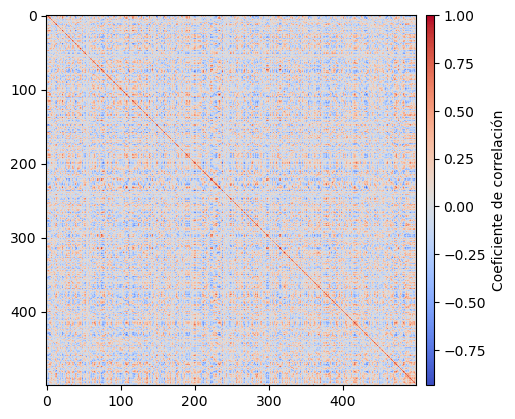

In [194]:
plot_heatmap(matriz_pear, cantidad=500, figsize = (5,5), cmap='coolwarm')

In [197]:
enlaces = matriz_pear.copy().to_numpy()

enlaces[np.tril_indices_from(enlaces, k=-1)] = 0
df = pd.DataFrame(enlaces, columns=matriz_pear.columns, index=matriz_pear.index)
df.head()

YAL001C   YAL002W   YAL003W   YAL004W   YAL005C   YAL007C   YAL008W  \
Proteina                                                                        
YAL001C       1.0  0.784409 -0.255929 -0.000721  0.124635 -0.135642  0.068274   
YAL002W       0.0  1.000000 -0.123425  0.319548  0.328560 -0.291349 -0.001941   
YAL003W       0.0  0.000000  1.000000  0.547065  0.622235  0.410656  0.247240   
YAL004W       0.0  0.000000  0.000000  1.000000  0.421385  0.195020  0.078229   
YAL005C       0.0  0.000000  0.000000  0.000000  1.000000  0.490343  0.529234   

           YAL009W   YAL010C   YAL011W  ...   YPR194C   YPR195C   YPR196W  \
Proteina                                ...                                 
YAL001C  -0.208016 -0.299033  0.302697  ...  0.110906  0.192338  0.053657   
YAL002W  -0.428036 -0.446571  0.461013  ... -0.267790  0.156363  0.049744   
YAL003W  -0.175059 -0.003965  0.073686  ... -0.376035  0.005696 -0.300600   
YAL004W  -0.540098 -0.166937  0.130986  ... -0.343021  0.282223 -0.040569   
YAL005C  -0.297900 -0.515094  0.285265  ... -0.578441 -0.027009  0.012542   

           YPR197C   YPR198W   YPR199C   YPR200C   YPR201W   YPR202W   YPR203W  
Proteina                                                                        
YAL001C  -0.280936  0.393633 -0.057262 -0.237002  0.371669  0.053529  0.024929  
YAL002W  -0.305974  0.368092 -0.187421 -0.604758  0.149767  0.125068  0.234124  
YAL003W   0.077396 -0.619781 -0.266689  0.030231 -0.170058 -0.161563 -0.110182  
YAL004W   0.437393 -0.452444 -0.556235 -0.384033  0.010244  0.374832  0.544893  
YAL005C  -0.418005 -0.374103 -0.192349 -0.362241 -0.150002 -0.149757  0.049754  

[5 rows x 6217 columns]

In [ ]:
# df.to_csv('../../Datos/transcriptomas/Matrices_javi/matriz_pearson_breeden_superior.csv', header=True, index=True) #47seg en guardar la matriz triangular superior

In [198]:
adyacencia = matriz_pear.copy()

#originalmente cota en 0.5
cota = 0.9
adyacencia[(matriz_pear >= -cota) & (matriz_pear <= cota)] = 0
adyacencia[(matriz_pear > cota) & (matriz_pear < 0.999999)] = 2
adyacencia[(matriz_pear < -cota)] = -2

adyacencia.head()

YAL001C  YAL002W  YAL003W  YAL004W  YAL005C  YAL007C  YAL008W  \
Proteina                                                                  
YAL001C       1.0      0.0      0.0      0.0      0.0      0.0      0.0   
YAL002W       0.0      1.0      0.0      0.0      0.0      0.0      0.0   
YAL003W       0.0      0.0      1.0      0.0      0.0      0.0      0.0   
YAL004W       0.0      0.0      0.0      1.0      0.0      0.0      0.0   
YAL005C       0.0      0.0      0.0      0.0      1.0      0.0      0.0   

          YAL009W  YAL010C  YAL011W  ...  YPR194C  YPR195C  YPR196W  YPR197C  \
Proteina                             ...                                       
YAL001C       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL002W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL003W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL004W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL005C       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

          YPR198W  YPR199C  YPR200C  YPR201W  YPR202W  YPR203W  
Proteina                                                        
YAL001C       0.0      0.0      0.0      0.0      0.0      0.0  
YAL002W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL003W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL004W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL005C       0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 6217 columns]

In [123]:
adyacencia.to_csv('../../Datos/transcriptomas/Matrices_javi/matriz_pearson_breeden_adyacencia-'+str(cota)+'.csv', header=True, index=True)

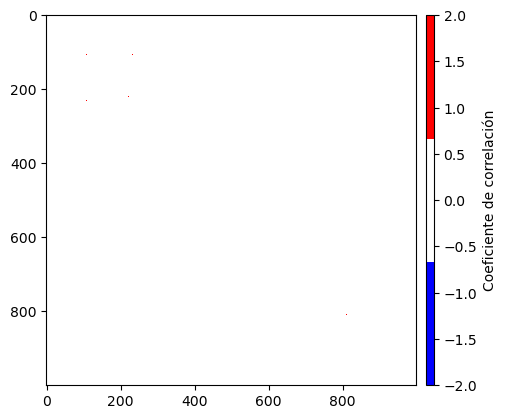

In [124]:
colors = ['blue', 'white', 'red']  # Colores para -2, 1, 2
cmap2 = ListedColormap(colors)

plot_heatmap(adyacencia, cantidad=1000, figsize=(5,5), cmap=cmap2)

### Trato de armar enlaces

In [125]:
adyacencia = pd.read_csv('../../Datos/transcriptomas/Matrices_javi/matriz_pearson_breeden_adyacencia-0.9.csv')
adyacencia = adyacencia.set_index('Proteina')

In [199]:
adyacencia_sin_diagonal = adyacencia.copy()
np.fill_diagonal(adyacencia_sin_diagonal.values, 0)
adyacencia_sin_diagonal.head()

YAL001C  YAL002W  YAL003W  YAL004W  YAL005C  YAL007C  YAL008W  \
Proteina                                                                  
YAL001C       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
YAL002W       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
YAL003W       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
YAL004W       0.0      0.0      0.0      0.0      0.0      0.0      0.0   
YAL005C       0.0      0.0      0.0      0.0      0.0      0.0      0.0   

          YAL009W  YAL010C  YAL011W  ...  YPR194C  YPR195C  YPR196W  YPR197C  \
Proteina                             ...                                       
YAL001C       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL002W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL003W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL004W       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   
YAL005C       0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0   

          YPR198W  YPR199C  YPR200C  YPR201W  YPR202W  YPR203W  
Proteina                                                        
YAL001C       0.0      0.0      0.0      0.0      0.0      0.0  
YAL002W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL003W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL004W       0.0      0.0      0.0      0.0      0.0      0.0  
YAL005C       0.0      0.0      0.0      0.0      0.0      0.0  

[5 rows x 6217 columns]

In [127]:
def assign_edge_colors(G):
    edge_colors = {2: 'plum',
        -2: 'lightseagreen'}

    nx.set_edge_attributes(G, {e: edge_colors.get(G[e[0]][e[1]]['weight'], 'black') for e in G.edges()}, 'color')

In [151]:
cantidad2 = 500
prueba = adyacencia_sin_diagonal.copy().iloc[0:cantidad2, 0:cantidad2]
# prueba

In [129]:
## Dada mi matriz de adyacencia, puedo hacer un grafo con networkx donde cada nodo sea una proteina dada por el nombre de la columna y cada arista
## tenga un color segun el valor de la matriz de adyacencia, los enlaces que tengan un valor de 2 seran de color rojo, los que tengan un valor de -2 seran de color azul, si hay otro
## valor no existirá la arista

G = nx.from_pandas_adjacency(prueba)

# Asignar colores a las aristas
assign_edge_colors(G)

In [130]:
G.number_of_edges()

97

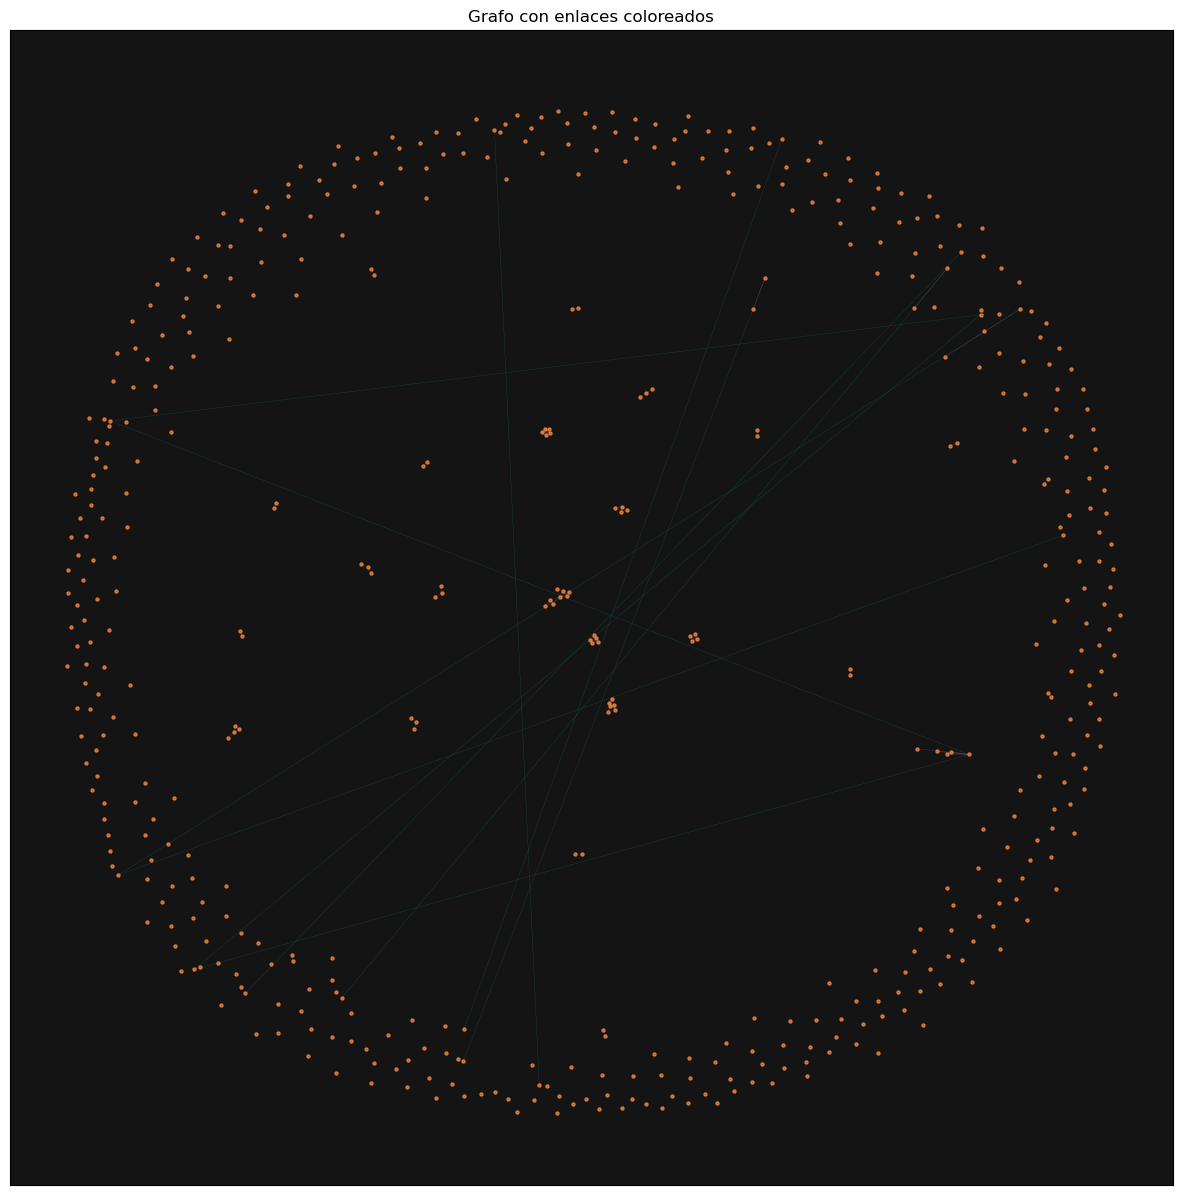

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))

pos = nx.spring_layout(G, seed=42)  # Posiciones de los nodos
edge_colors = nx.get_edge_attributes(G, 'color').values()

# nx.draw(G, pos, with_labels=False, edge_color=list(edge_colors), node_size=5, node_color='k', alpha=0.7, width=0.2)

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(G,
						   pos = pos,
						   node_color = '#FF8C42',
						   ax = ax,
						   node_size = 5, alpha = 0.7)
	
	nx.draw_networkx_edges(G, pos = pos, ax = ax, alpha = .4, edge_color = list(edge_colors), width = 0.2)

plt.legend(handles=[mpatches.Patch(color='plum', label='Correlación positiva'), mpatches.Patch(color='lightseagreen', label='Correlación negativo')])
plt.title("Grafo con enlaces coloreados")
plt.show()

In [135]:
G.number_of_edges()

14359

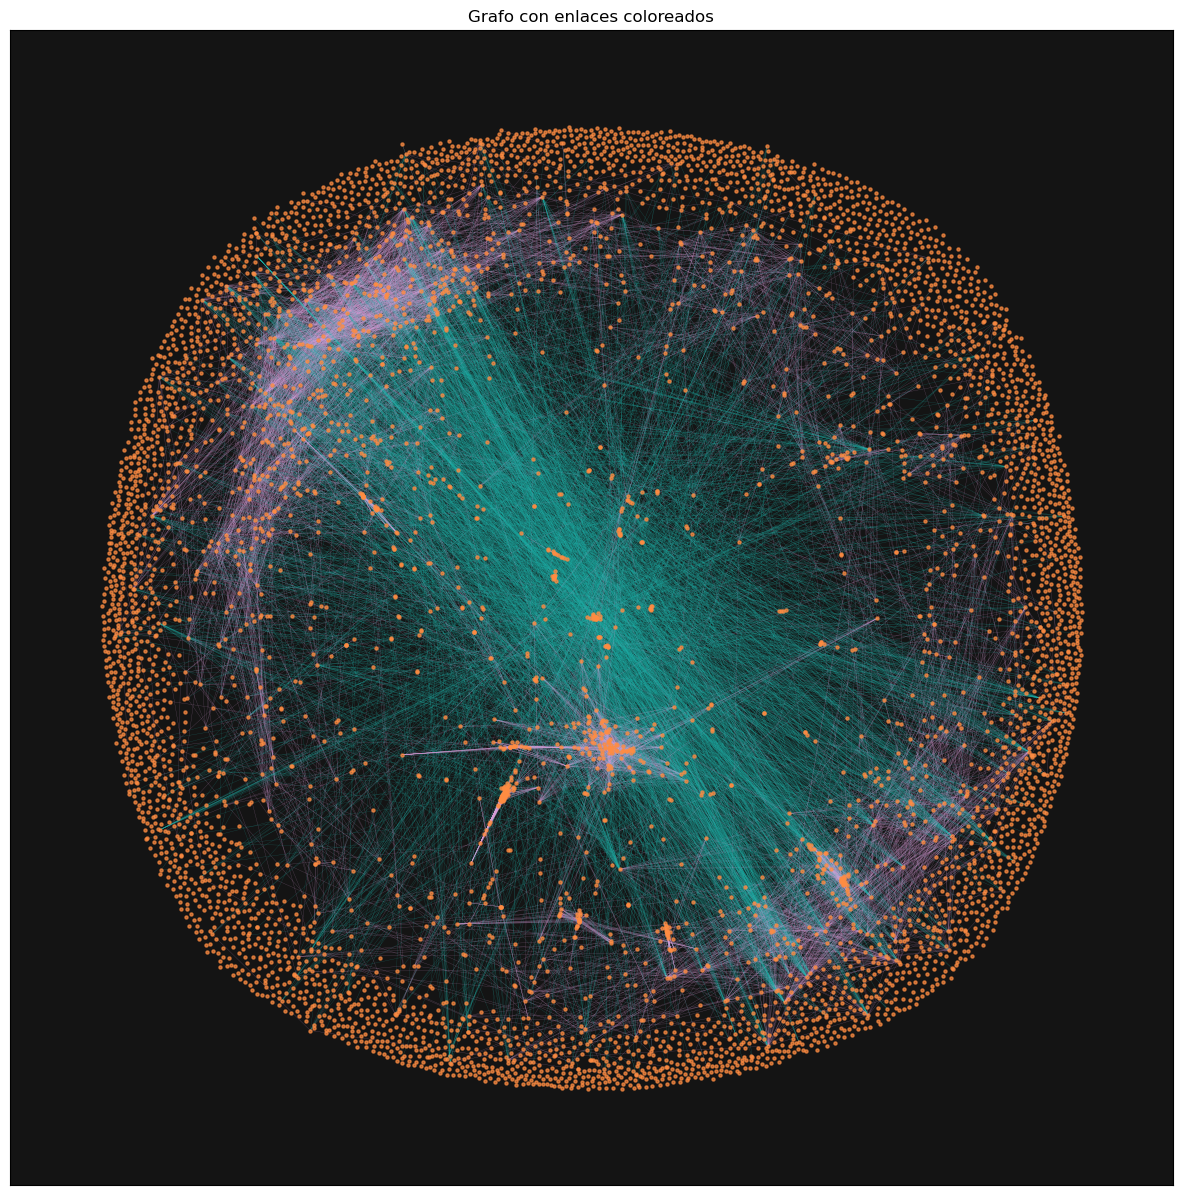

In [ ]:
#Le doy a todo
G = nx.from_pandas_adjacency(adyacencia_sin_diagonal)

# Asignar colores a las aristas
assign_edge_colors(G)

fig, ax = plt.subplots(1, 1, figsize = (15,15))

pos = nx.spring_layout(G, seed=42)  # Posiciones de los nodos
edge_colors = nx.get_edge_attributes(G, 'color').values()

# nx.draw(G, pos, with_labels=False, edge_color=list(edge_colors), node_size=5, node_color='k', alpha=0.7, width=0.2)

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(G,
						   pos = pos,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 5, alpha = 0.7)
	
	nx.draw_networkx_edges(G, pos = pos, ax = ax, alpha = .4, edge_color = list(edge_colors), width = 0.2)

plt.legend(handles=[mpatches.Patch(color='plum', label='Correlación positiva'), mpatches.Patch(color='lightseagreen', label='Correlación negativo')])
plt.title("Grafo con enlaces coloreados")
plt.show()

In [178]:
G2 = G.copy()


for u, v, data in G2.edges(data=True):
    if data['weight'] == -2.0 or data['weight'] == 2.0:
        data['weight'] = 1.0
        
# G2.edges(data=True)

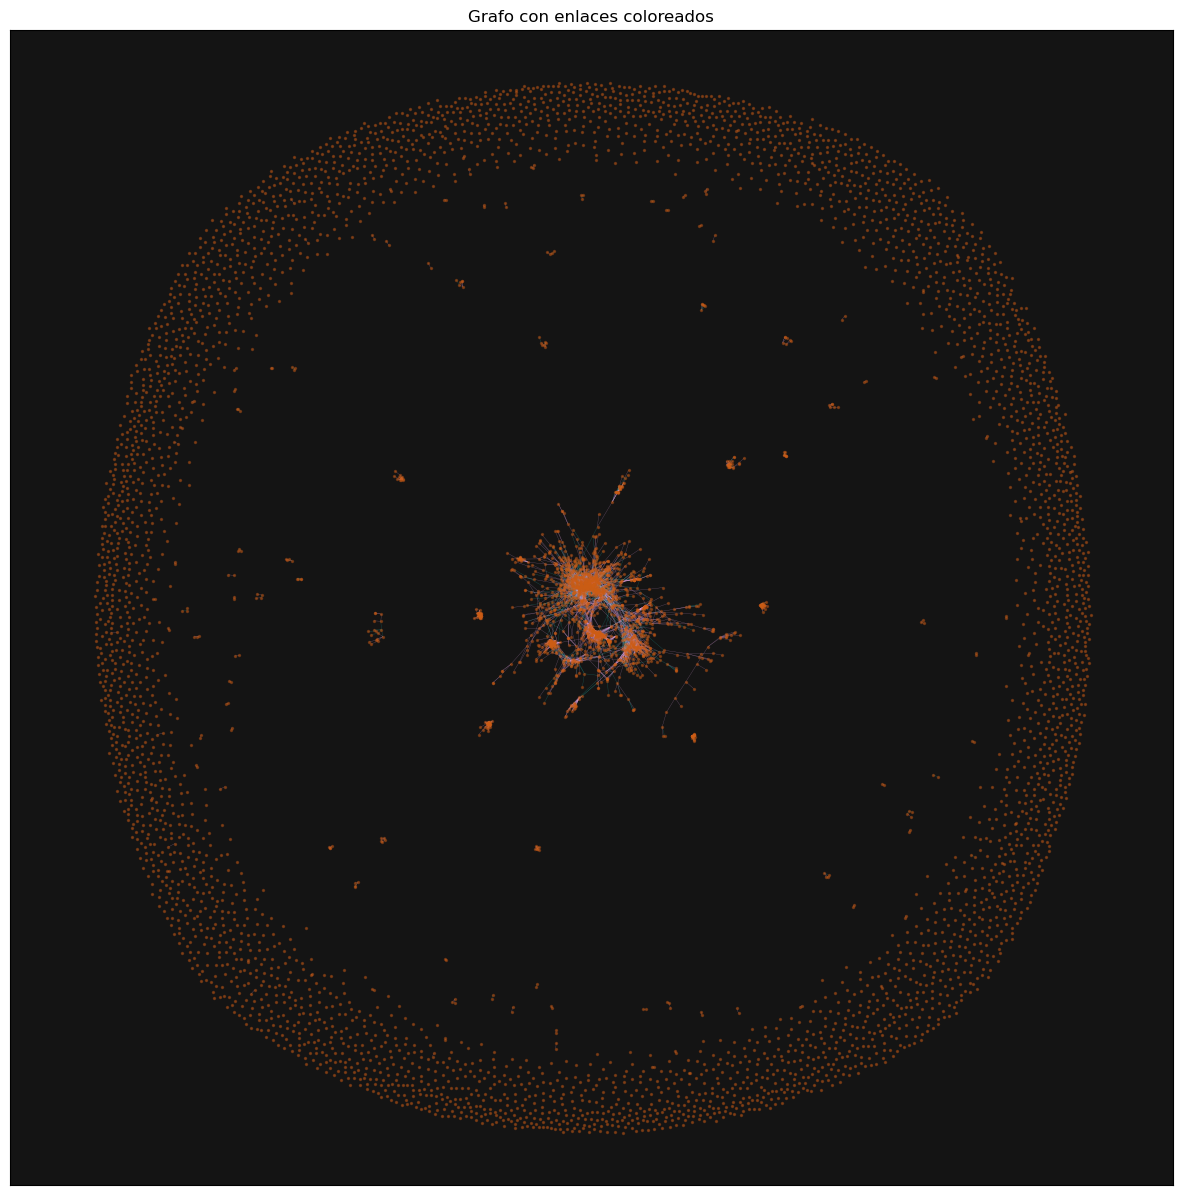

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))

# pos = nx.kamada_kawai_layout(G2)  # Posiciones de los nodos
pos = nx.spring_layout(G2, seed=42)  # Posiciones de los nodos
edge_colors = nx.get_edge_attributes(G2, 'color').values()

# nx.draw(G, pos, with_labels=False, edge_color=list(edge_colors), node_size=5, node_color='k', alpha=0.7, width=0.2)

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(G2,
						   pos = pos,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(G2, pos = pos, ax = ax, alpha = .5, edge_color = list(edge_colors), width = 0.2)

plt.legend(handles=[mpatches.Patch(color='plum', label='Correlación positiva'), mpatches.Patch(color='lightseagreen', label='Correlación negativo')])
plt.title("Grafo con enlaces coloreados")
plt.show()

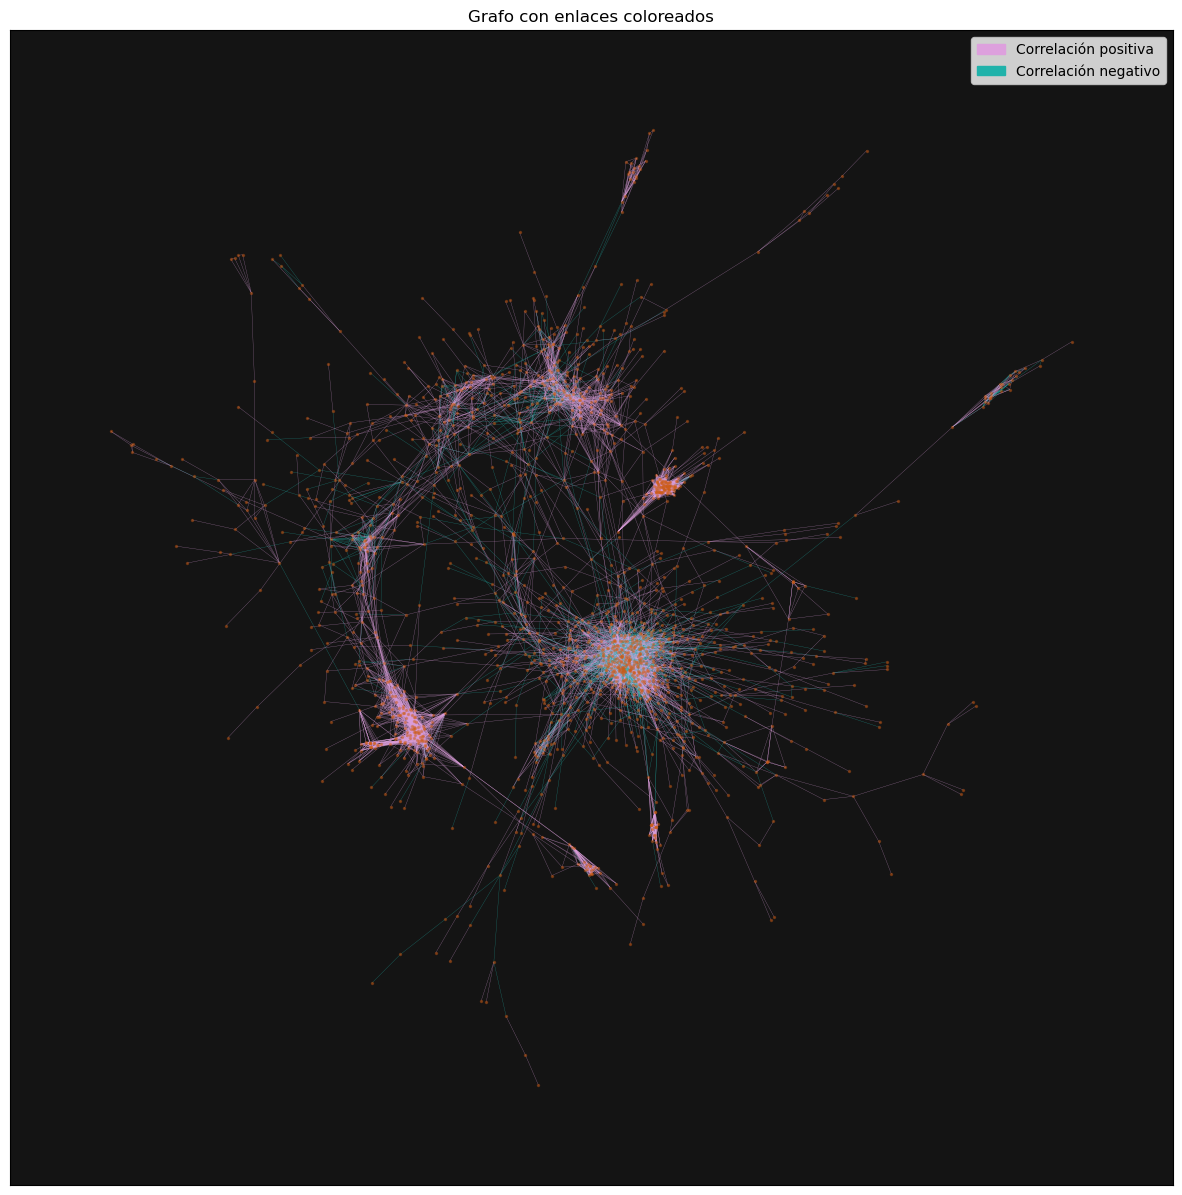

In [164]:
# Tomo la componente gigante:

componentes = nx.connected_components(G2)
componentes = list(componentes)
componentes.sort(key=len, reverse=True)
componente_gigante = G2.subgraph(componentes[0])


fig, ax = plt.subplots(1, 1, figsize = (15,15))

# pos = nx.kamada_kawai_layout(G2)  # Posiciones de los nodos
pos = nx.spring_layout(componente_gigante, seed=42)  # Posiciones de los nodos
edge_colors = nx.get_edge_attributes(componente_gigante, 'color').values()

# nx.draw(G, pos, with_labels=False, edge_color=list(edge_colors), node_size=5, node_color='k', alpha=0.7, width=0.2)

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(componente_gigante,
						   pos = pos,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(componente_gigante, pos = pos, ax = ax, alpha = .7, edge_color = list(edge_colors), width = 0.2)


plt.legend(handles=[mpatches.Patch(color='plum', label='Correlación positiva'), mpatches.Patch(color='lightseagreen', label='Correlación negativo')])
plt.title("Grafo con enlaces coloreados")
plt.show()

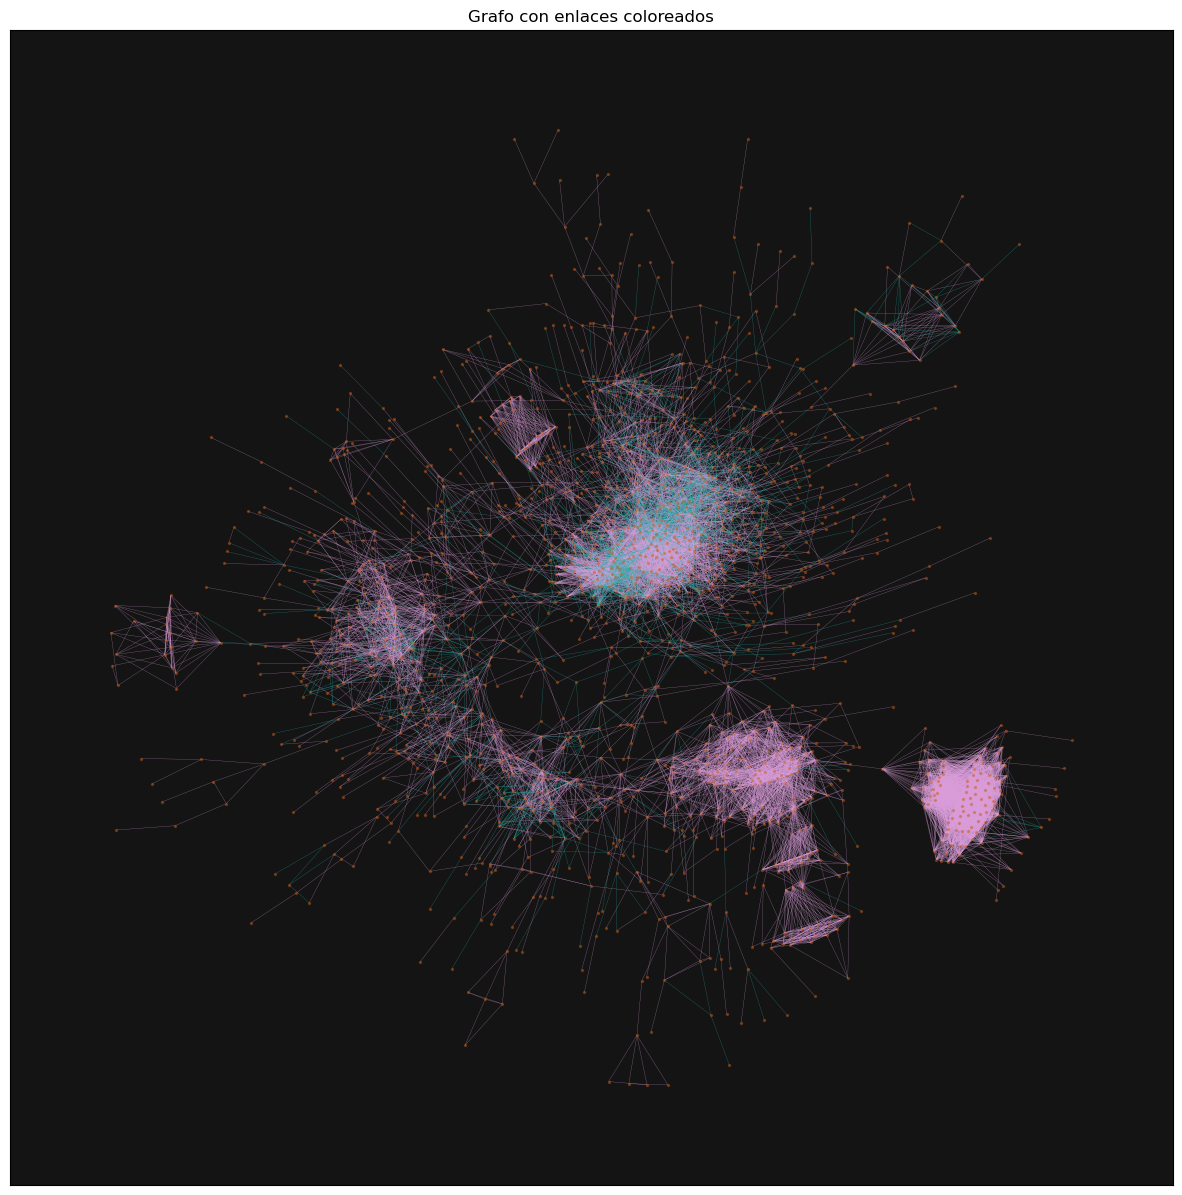

In [ ]:
# Tomo la componente gigante:

componentes = nx.connected_components(G2)
componentes = list(componentes)
componentes.sort(key=len, reverse=True)
componente_gigante = G2.subgraph(componentes[0])


fig, ax = plt.subplots(1, 1, figsize = (15,15))

pos = nx.kamada_kawai_layout(G2)  # Posiciones de los nodos
# pos = nx.spring_layout(componente_gigante, seed=42)  # Posiciones de los nodos
edge_colors = nx.get_edge_attributes(componente_gigante, 'color').values()

# nx.draw(G, pos, with_labels=False, edge_color=list(edge_colors), node_size=5, node_color='k', alpha=0.7, width=0.2)

for i, ax in enumerate(fig.axes):
	ax.set_facecolor('#141414')  # Cambiar color de background
	nx.draw_networkx_nodes(componente_gigante,
						   pos = pos,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(componente_gigante, pos = pos, ax = ax, alpha = .7, edge_color = list(edge_colors), width = 0.2)

plt.legend(handles=[mpatches.Patch(color='plum', label='Correlación positiva'), mpatches.Patch(color='lightseagreen', label='Correlación negativo')])
plt.title("Grafo con enlaces coloreados")
plt.show()

In [161]:
# Ahora voy a probar armando 2 subgrafos, uno con las aristas de color rojo y otro con las aristas de color azul

G_positiva = G.copy()
G_negativa = G.copy()

for u, v, data in G.edges(data=True):
	if data['weight'] == -2.0:
		G_positiva.remove_edge(u, v)
	elif data['weight'] == 2.0:
		G_negativa.remove_edge(u, v)
                
#Cambio a peso 1 las aristas que quedaron
for u, v, data in G_positiva.edges(data=True):
	if data['weight'] == 2.0:
		data['weight'] = 1.0

for u, v, data in G_negativa.edges(data=True):
	if data['weight'] == -2.0:
		data['weight'] = 1.0

In [162]:
G_positiva.number_of_edges(), G_negativa.number_of_edges(), G.number_of_edges()

(11972, 2387, 14359)

0 11972
1 2387


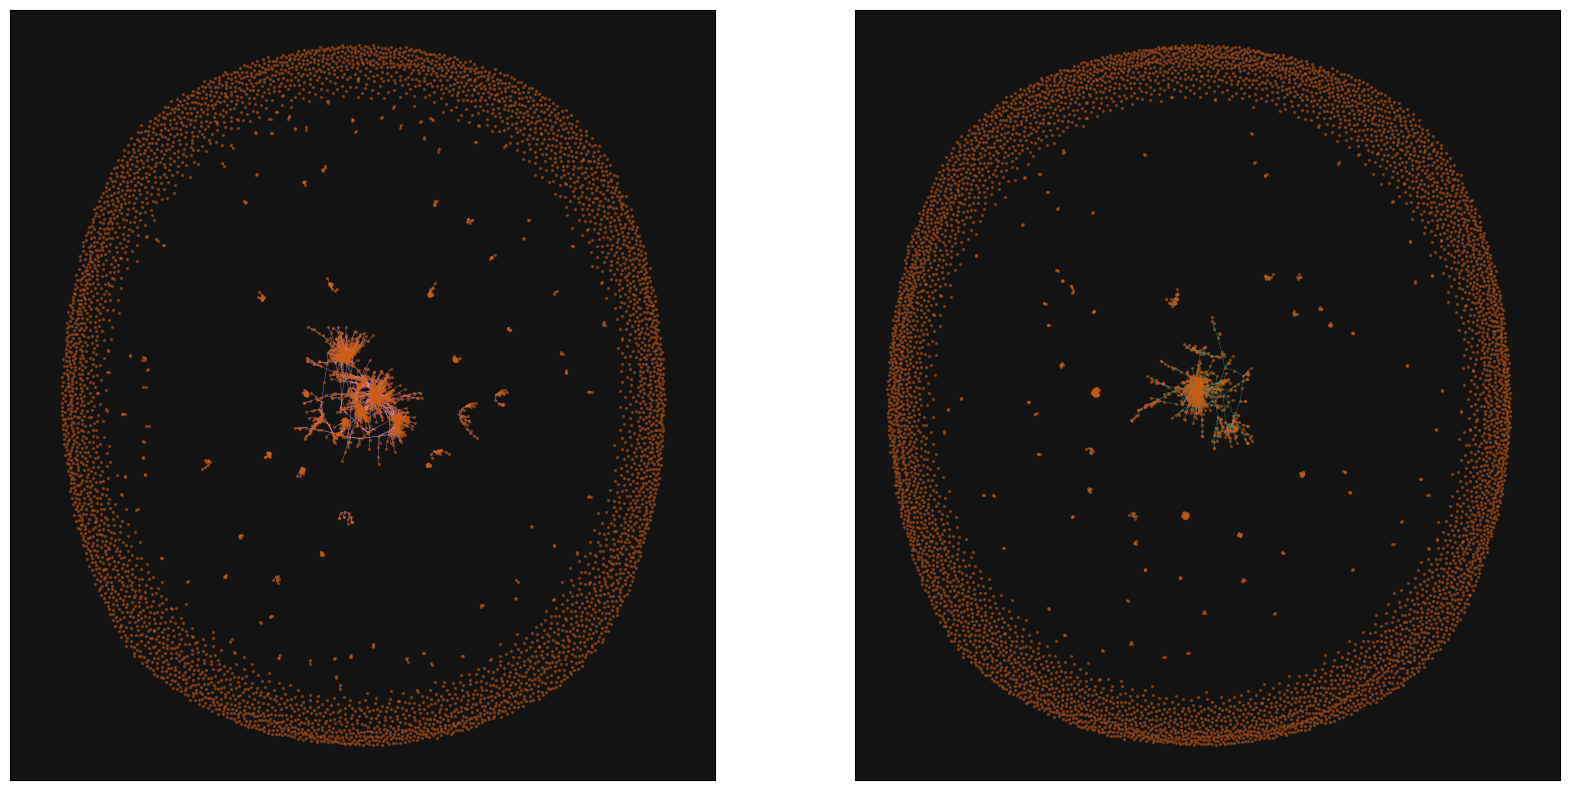

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'wspace': 0.1})

Gs = [G_positiva, G_negativa]

for i, ax in enumerate(axes):
	print(i, Gs[i].number_of_edges())
	pos = nx.spring_layout(Gs[i], seed=42)
	edge_colors = nx.get_edge_attributes(Gs[i], 'color').values()
	ax.set_facecolor('#141414') 
	nx.draw_networkx_nodes(Gs[i],
						   pos = pos,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(Gs[i], pos = pos, ax = ax, alpha = .7, edge_color = list(edge_colors), width = 0.3)

# axes[0].legend(handles=[mpatches.Patch(color='plum', label='Correlación positiva'), mpatches.Patch(color='lightseagreen', label='Correlación negativo')])
plt.show()

In [175]:
def gigante(G):
	componentes = nx.connected_components(G)
	componentes = list(componentes)
	componentes.sort(key=len, reverse=True)
	componente_gigante = G.subgraph(componentes[0])
	return componente_gigante

# me quedo con la componente gigante de cada uno

gigante_pos = gigante(G_positiva)
gigante_neg = gigante(G_negativa)

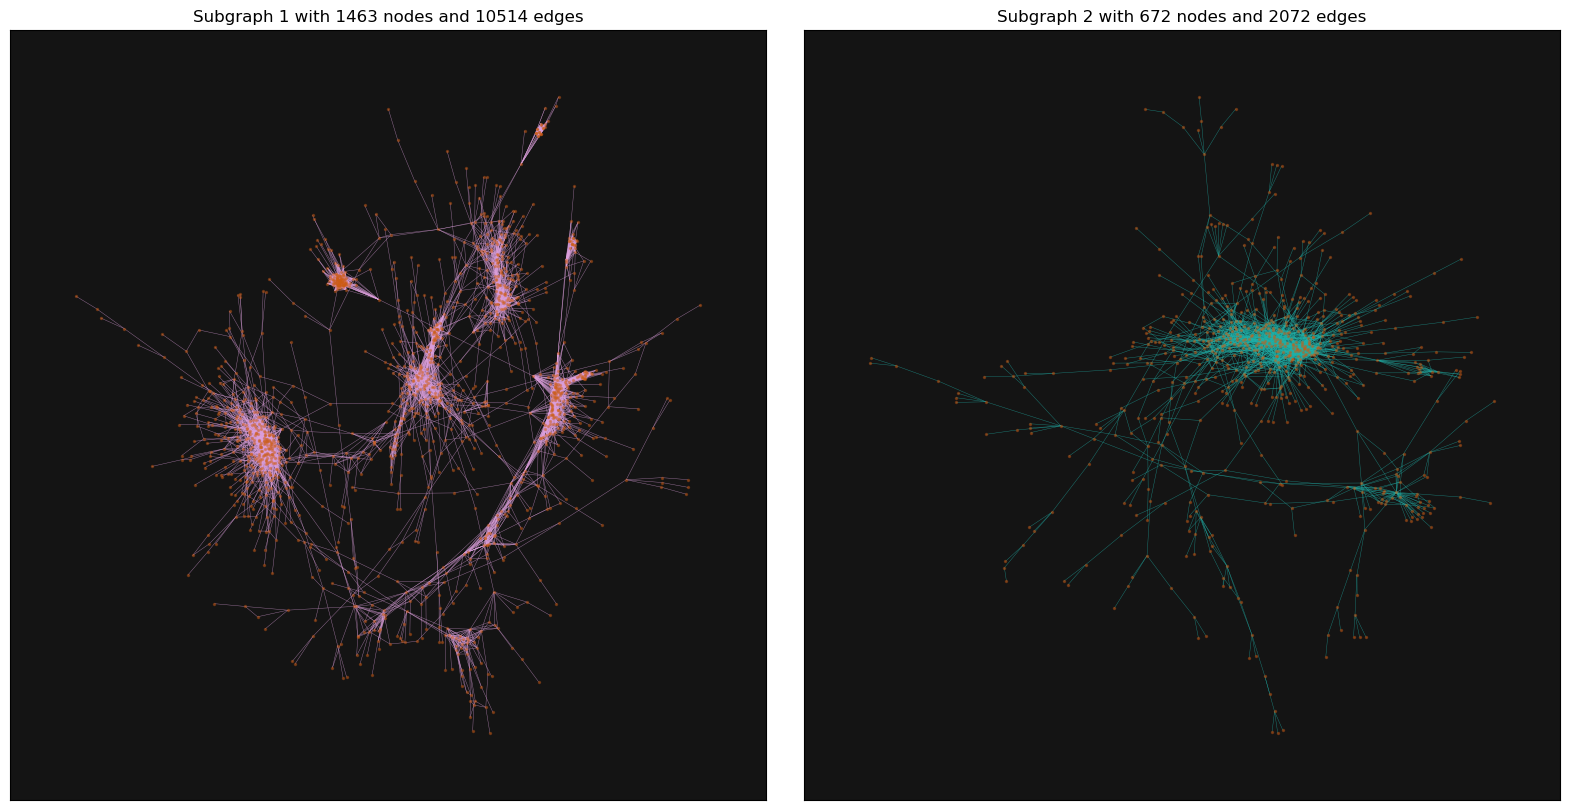

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10), gridspec_kw={'wspace': 0.05})

gigantes = [gigante_pos, gigante_neg]

for i, ax in enumerate(axes):
	# print(gigantes[i].number_of_edges())
	pos = nx.spring_layout(gigantes[i], seed=42)
	edge_colors = nx.get_edge_attributes(gigantes[i], 'color').values()
	ax.set_facecolor('#141414') 
	nx.draw_networkx_nodes(gigantes[i],
						   pos = pos,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(gigantes[i], pos = pos, ax = ax, alpha = .7, edge_color = list(edge_colors), width = 0.3)
	ax.set_title(f"Subgraph {i+1} with {gigantes[i].number_of_nodes()} nodes and {gigantes[i].number_of_edges()} edges")

## Abro archivo de interacciones entre proteinas

In [195]:
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data

In [196]:
interacciones_apms = abrir_txt('/content/yeast_AP-MS.txt')
interacciones_apms[:10]

[['YAL001C', 'YBR123C'],
 ['YAL001C', 'YDR362C'],
 ['YAL001C', 'YGR047C'],
 ['YAL001C', 'YOR110W'],
 ['YAL001C', 'YPL007C'],
 ['YAL002W', 'YLR148W'],
 ['YAL002W', 'YLR396C'],
 ['YAL002W', 'YMR231W'],
 ['YAL002W', 'YPL045W'],
 ['YAL003W', 'YEL034W']]

In [206]:
apms = nx.Graph()
apms.add_edges_from(interacciones_apms)

apms.number_of_edges(), apms.number_of_nodes()

(9070, 1622)

In [ ]:
common_edges_graph = nx.Graph()

# Iterar por las aristas de pos
for edge in gigante_pos.edges:
    if apms.has_edge(*edge):
        common_edges_graph.add_edge(*edge)


In [210]:
common_edges_graph.number_of_edges(), common_edges_graph.number_of_nodes()

(65, 71)

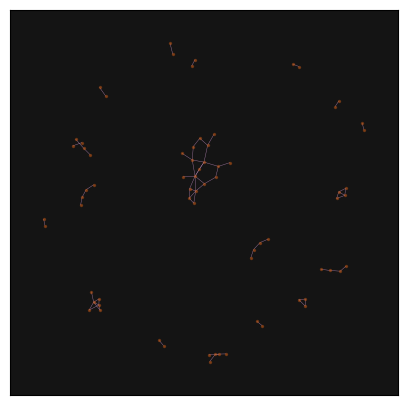

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = (5,5))

for i, ax in enumerate(fig.axes):
	# print(gigantes[i].number_of_edges())
	pos = nx.spring_layout(common_edges_graph, seed=42)
	edge_colors = nx.get_edge_attributes(common_edges_graph, 'color').values()
	ax.set_facecolor('#141414') 
	nx.draw_networkx_nodes(common_edges_graph,
						   pos = pos,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(common_edges_graph, pos = pos, ax = ax, alpha = .7, edge_color = 'plum', width = 0.3)


In [ ]:
merged_graph = nx.Graph()

# Procesar las aristas de ambos grafos
for edge in gigante_pos.edges:
    if apms.has_edge(*edge):  # Pertenece a ambos
        merged_graph.add_edge(*edge, color='green')
    else:  # Solo pertenece a pos
        merged_graph.add_edge(*edge, color='blue')

for edge in apms.edges:
    if not gigante_pos.has_edge(*edge):  # Solo pertenece a apms
        merged_graph.add_edge(*edge, color='red')

# Ahora merged_graph contiene todas las aristas con los colores asignados


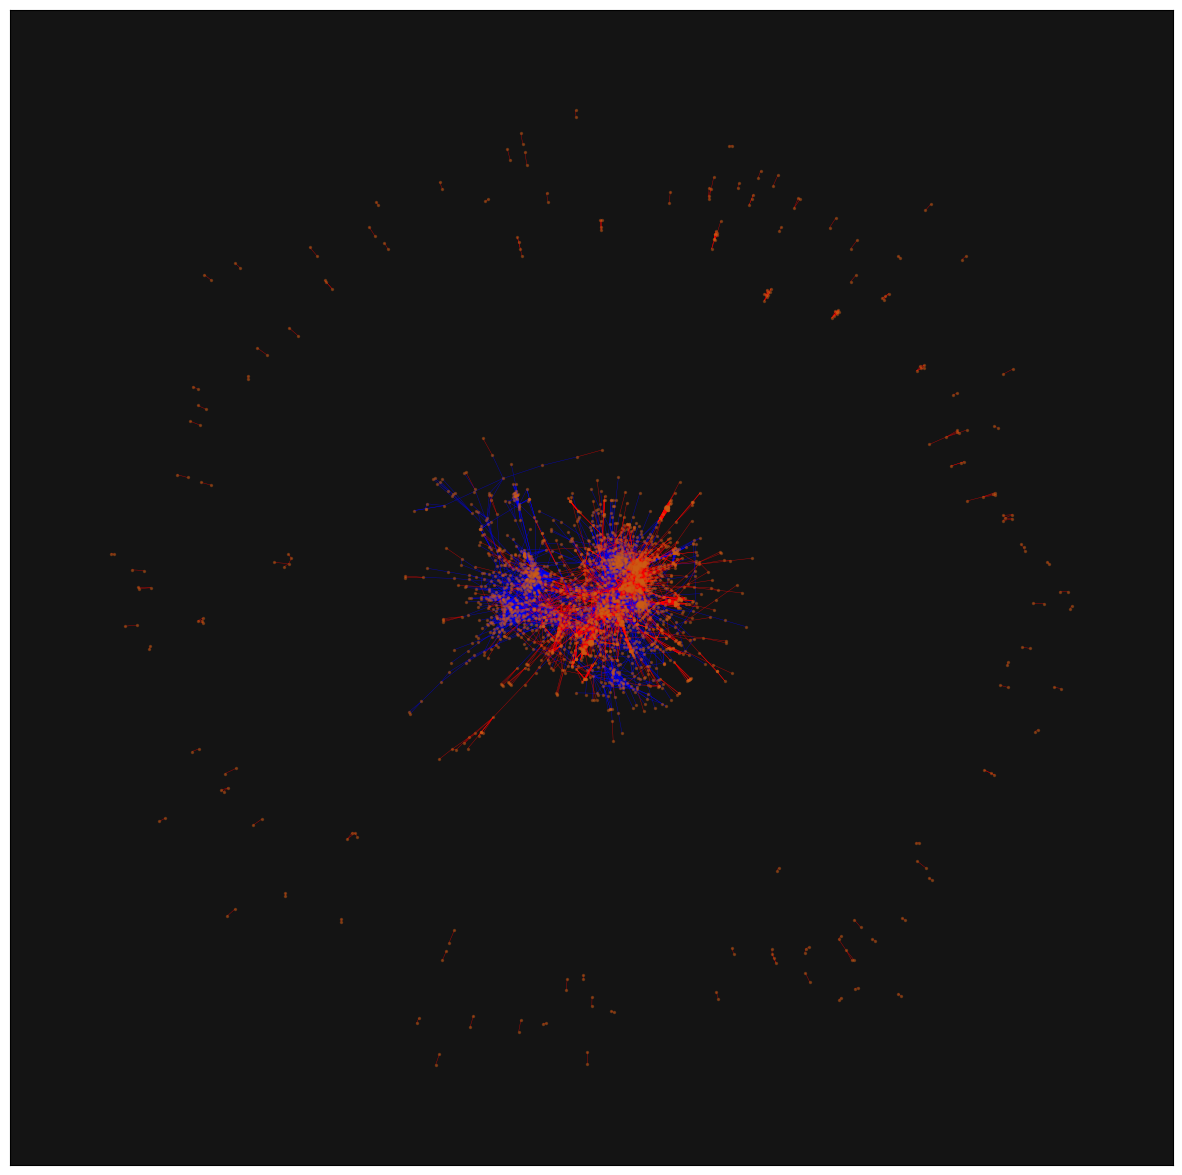

In [222]:
# Dibujar el grafo
pos_layout = nx.spring_layout(merged_graph)  # Layout para la posición de los nodos
edges = merged_graph.edges(data=True)

fig, axes = plt.subplots(1, 1, figsize = (15,15))

for i, ax in enumerate(fig.axes):
	# print(gigantes[i].number_of_edges())
	pos = nx.spring_layout(merged_graph, seed=42)
	edge_colors = [attr['color'] for _, _, attr in edges]
	ax.set_facecolor('#141414') 
	nx.draw_networkx_nodes(merged_graph,
						   pos = pos_layout,
						   node_color = '#cc5c14',
						   ax = ax,
						   node_size = 2, alpha = 0.4)
	
	nx.draw_networkx_edges(merged_graph, pos = pos_layout, ax = ax, alpha = .7, edge_color = edge_colors, width = 0.3)


In [232]:
def plot_grafo(grafo):
	pos_layout = nx.spring_layout(grafo)  # Layout para la posición de los nodos
	edges = grafo.edges(data=True)

	fig, axes = plt.subplots(1, 1, figsize = (10,10))

	for i, ax in enumerate(fig.axes):
		pos = nx.spring_layout(grafo, seed=42)
		edge_colors = nx.get_edge_attributes(grafo, 'color').values()
		ax.set_facecolor('#141414') 
		nx.draw_networkx_nodes(grafo,
							pos = pos_layout,
							node_color = '#cc5c14',
							ax = ax,
							node_size = 2, alpha = 0.4)
		
		nx.draw_networkx_edges(grafo, pos = pos_layout, ax = ax, alpha = .7, edge_color = edge_colors, width = 0.3)

In [223]:
merged_graph.edges(data=True)

EdgeDataView([('YJR062C', 'YER133W', {'color': 'blue'}), ('YJR062C', 'YML049C', {'color': 'blue'}), ('YJR062C', 'YOR046C', {'color': 'blue'}), ('YER133W', 'YIL130W', {'color': 'blue'}), ('YER133W', 'YMR125W', {'color': 'blue'}), ('YER133W', 'YMR119W', {'color': 'blue'}), ('YER133W', 'YGL190C', {'color': 'blue'}), ('YER133W', 'YGR046W', {'color': 'blue'}), ('YER133W', 'YPL160W', {'color': 'blue'}), ('YER133W', 'YDL147W', {'color': 'blue'}), ('YER133W', 'YGR218W', {'color': 'blue'}), ('YER133W', 'YJL041W', {'color': 'blue'}), ('YER133W', 'YKR059W', {'color': 'blue'}), ('YER133W', 'YBR143C', {'color': 'blue'}), ('YER133W', 'YBL076C', {'color': 'blue'}), ('YER133W', 'YDR091C', {'color': 'blue'}), ('YER133W', 'YMR309C', {'color': 'blue'}), ('YER133W', 'YPL204W', {'color': 'blue'}), ('YER133W', 'YCL031C', {'color': 'blue'}), ('YER133W', 'YLR197W', {'color': 'blue'}), ('YER133W', 'YOR030W', {'color': 'blue'}), ('YER133W', 'YCR028C', {'color': 'blue'}), ('YER133W', 'YOR168W', {'color': 'blue'}

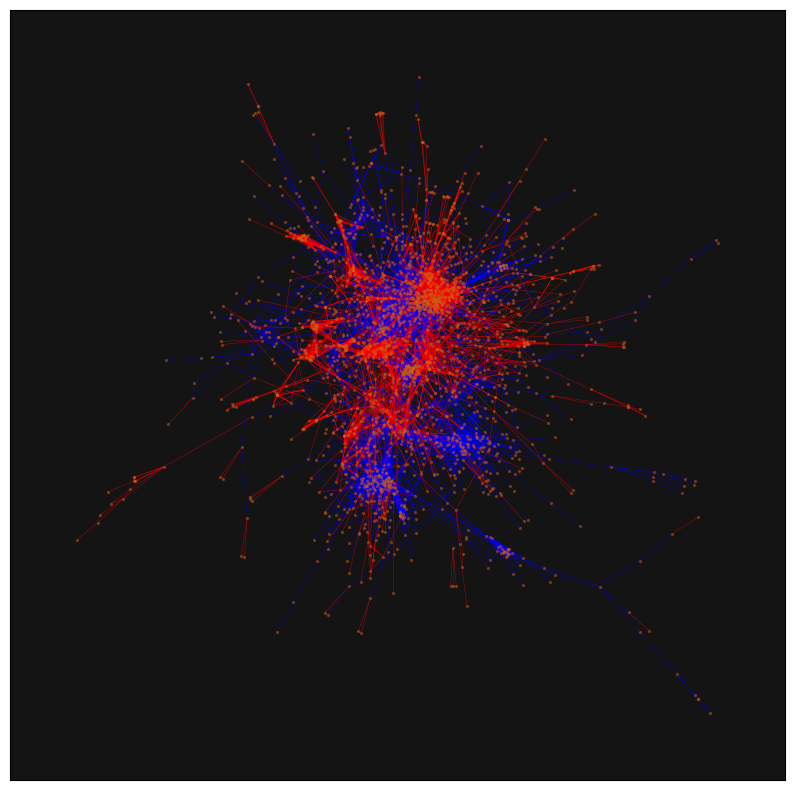

In [233]:
gigante_merge = gigante(merged_graph)
plot_grafo(gigante_merge)
